In [2]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np

In [16]:
df_list = []
for i in [14, 15,18,23,28,30, 31]:
    df_list.append(pd.read_csv(f"../output/{i}/oof_df.csv"))
basic_df= df_list[0].loc[:, ["Id", "Pawpularity", "fold"]]
df_list = list(map(lambda x:x.loc[:,"preds"], df_list))

In [17]:
df = pd.concat(df_list, axis=1)
df = pd.concat([basic_df, df], axis=1)
df.head()

,Id,Pawpularity,fold,preds,preds,preds,preds,preds,preds,preds
0,0031d6a9ef7340f898c3e05f92c7bb04,35,0,45.136406,38.146786,38.470844,42.552150,35.648610,41.240234,43.293716
1,0042bc5bada6d1cf8951f8f9f0d399fa,53,0,59.318428,56.171696,57.961920,56.609673,43.608013,54.898148,54.999744
2,00655425c10d4c082dd7eeb97fa4fb17,13,0,23.322584,26.374268,29.012499,25.336117,24.612621,28.339142,23.610350
3,0067aaaa500b530c76b9c91af34b4cb8,98,0,71.188170,69.635570,68.687096,74.973880,64.288480,70.338930,68.767494
4,006fe962f5f7e2c5f527b2e27e28ed6d,69,0,51.895363,58.869343,42.906060,55.458294,55.906670,50.743440,50.293070


In [18]:
from sklearn.linear_model import Ridge
CV_score=[]
preds = []
def postprocess(
    pred,
    target_dist,alpha = 0.2
) -> pd.Series:
    """検証フェーズ
    与えられたモデル・データローダを
    使って検証フェーズを実行。スコアの dict と予測した値を返す
    """
    target_dist = pd.cut(target_dist, list(range(0,105, 5)), labels=False)
    target_dist = target_dist.value_counts(normalize=True).sort_index()
    sorted_index = np.argsort(pred)
    sample_num = len(pred)
    pred_n = pred.copy()
    ratio = 0
    for idx,d in enumerate(target_dist.values):
        pred_n[sorted_index[int(ratio*sample_num):int((ratio+d)*sample_num)]] = idx * 5
        ratio += d
    pred_n[sorted_index[-1]] = 100
    pred = pred_n * alpha + pred * (1-alpha)
    print(pred_n)
    return pred

for fold in range(5):
    df_=df.drop(columns=["Id"])
    tr_x, tr_y = df_[df_.fold!=fold].drop(columns=["Pawpularity", "fold"]), df_[df_.fold!=fold].Pawpularity
    val_x, val_y =  df_[df_.fold==fold].drop(columns=["Pawpularity", "fold"]), df_[df_.fold==fold].Pawpularity
    lr = LinearRegression()
    lr.fit(tr_x, tr_y)
    pred = lr.predict(val_x)
    preds.append(pred)
    score = np.sqrt(np.mean((np.array(pred)- np.array(val_y))**2))
    CV_score.append(score)
    
    print(f"fold{fold}:{score}")
print(f"CV:{sum(CV_score)/len(CV_score)}")
df['final_pred']=np.concatenate(preds)

fold0:17.34119708509924
fold1:17.405549812605972
fold2:17.406202127064486
fold3:17.427009398169357
fold4:17.299738299240925
CV:17.375939344436


Text(114.0, 0.5, 'Pawpularity_bin')

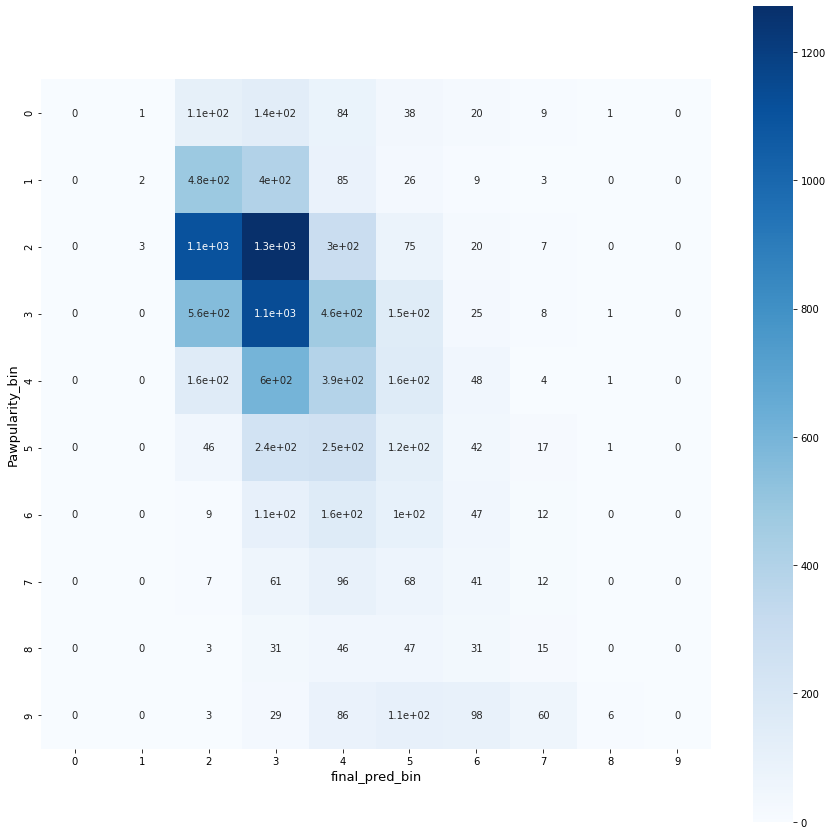

In [128]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
df["Pawpularity_bin"] = pd.cut(df["Pawpularity"], list(range(0,110, 10)), labels=False)
df["final_pred_bin"] = pd.cut(df["final_pred"], list(range(0,110, 10)), labels=False)
cm = confusion_matrix(df["Pawpularity_bin"], df['final_pred_bin'])
plt.figure(figsize=(15,15))
sns.heatmap(cm, square=True, cbar=True, annot=True, cmap='Blues')
plt.xlabel("final_pred_bin", fontsize=13)
plt.ylabel("Pawpularity_bin", fontsize=13)
# sns.scatterplot(df["Pawpularity"][:100], df['final_pred'][:100])

In [96]:
df

,Id,Pawpularity,fold,preds,preds,preds,preds,preds,preds,preds,preds,final_pred,Pawpularity_bin,final_pred_bin
0,0031d6a9ef7340f898c3e05f92c7bb04,35,0,45.136406,38.146786,38.470844,42.552150,35.648610,41.240234,43.293716,40.605850,41.113540,3,4
1,0042bc5bada6d1cf8951f8f9f0d399fa,53,0,59.318428,56.171696,57.961920,56.609673,43.608013,54.898148,54.999744,52.569496,57.425867,5,5
2,00655425c10d4c082dd7eeb97fa4fb17,13,0,23.322584,26.374268,29.012499,25.336117,24.612621,28.339142,23.610350,22.784788,25.161877,1,2
3,0067aaaa500b530c76b9c91af34b4cb8,98,0,71.188170,69.635570,68.687096,74.973880,64.288480,70.338930,68.767494,68.141235,73.932940,9,7
4,006fe962f5f7e2c5f527b2e27e28ed6d,69,0,51.895363,58.869343,42.906060,55.458294,55.906670,50.743440,50.293070,52.180855,53.856146,6,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9907,ff08dcc0387d193a21c1c50635030a06,73,4,51.351578,60.385620,47.346240,50.533314,54.253025,48.195090,52.539074,64.148940,54.555511,7,5
9908,ff6123b262da1a561197a5a25c212964,23,4,36.620070,38.751200,32.549183,34.114983,39.146960,39.288372,31.356407,32.963516,35.725590,2,3
9909,ff6591fb1b3481fe0c366dfdcdc8ab5f,30,4,26.409695,28.562153,25.879120,25.021795,37.060654,31.064170,29.788204,26.616627,28.828236,2,2
9910,ffdf2e8673a1da6fb80342fa3b119a20,20,4,22.250675,28.532127,22.281046,30.507820,28.927448,30.745052,21.860685,24.796055,24.862399,1,2


In [72]:
df.final_pred.std()

11.198548796678974

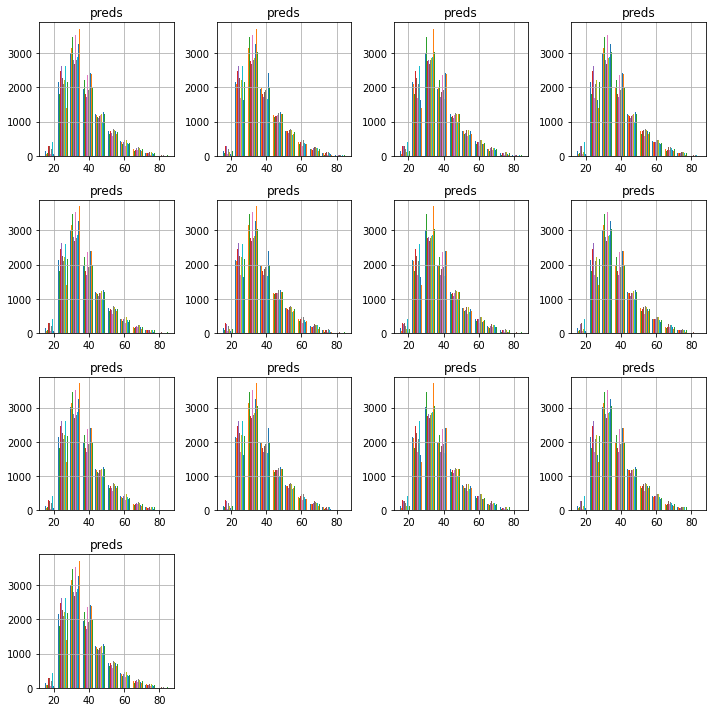

In [73]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10
df.preds.hist()
plt.tight_layout()
plt.show() 

<AxesSubplot:>

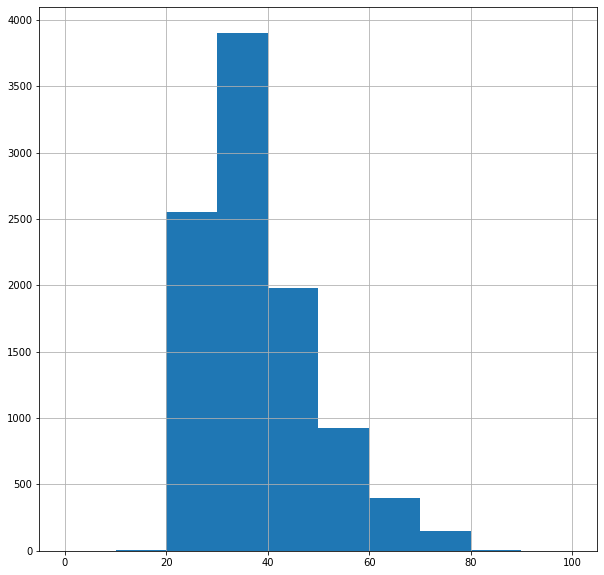

In [74]:
df.final_pred.hist(range=(0,100)) 

<AxesSubplot:>

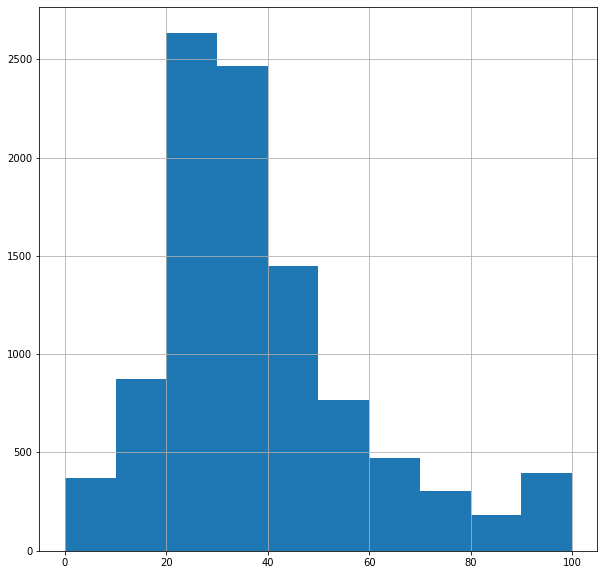

In [75]:
df.Pawpularity.hist(range=(0,100)) 

In [ ]:
alpha * pred + (1-alpha) * pred